In [1]:
# simple notebook that shows how one can use graphql queries for data analysis

In [2]:
%matplotlib inline

In [3]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [4]:
URL = 'https://api.thegraph.com/subgraphs/id/QmUki7i1uPWYunwGyGq81VHaTohSJTEP1AMeu9tbXGSM3j'
# number of events to return in one request (max: 1000)
STEP = 1000

In [5]:
# query returns all (paginated) summoned wizards
def query(first=STEP, skip=0):
    q = (
        "{"
        "wizards(first:" + str(first) + ", " + "skip:" +  str(skip) + ") {"
        "id "
        "tokenId "
            "power "
            "owner "
            "element "
            "costWei "
            "blockNumber "
          "}"
        "}"
    ) 
    return q

In [6]:
def perform_request(url, query):
    request = requests.post(url, json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [7]:
result = []
j = 0
while (True):
    r = perform_request(URL, query(STEP, j*STEP))
    if len(r['data']['wizards']) is 0:
        break
    result.extend(r['data']['wizards'])
    j += 1

In [8]:
df = pd.DataFrame.from_records(
    result
)

In [9]:
df.head()

,blockNumber,costWei,element,id,owner,power,tokenId
0,7781256,70000,1,0x000eead03c871a38ada29d0c5e93b2616da659d1454f...,0x8e1788f0f367542cfe2b81c3b43bc761cd1cba77,70,2485
1,7792622,70000,1,0x0024f9444c65af8b9ebe3ed08f2a421eb04cd4628e69...,0x4a9e7db01e359a3ff888e623dc41b38590b49d7b,70,3735
2,7783575,399160,4,0x002502f0a00864843f60121ace31dd3c59e0c922e13b...,0x16fce6f6b5579469e48cb9633105f36a52a0f9a6,399,3012
3,7782446,333212,3,0x002b0a8dccd55bfb239d353209d8b175ea3aac0b0bea...,0xfbdbcf1ebe27245e3488541f19cac902e53239a4,333,2811
4,7804891,70000,1,0x003fc311f62d3db875b467222cad13b75e49b7206bbe...,0x24cb9a6fb711911c53afa4d89c2fe8fbda034c41,70,4381


In [10]:
for col in ['blockNumber', 'costWei']:
    df[col] = df[col].astype(np.int64)

In [11]:
wizard_colors = {
    1: '#A66EFF', # ELEMENT_NEUTRAL
    2: '#FF506E', # ELEMENT_FIRE
    3: '#66EDFF', # ELEMENT_WATER
    4: '#84FF61', # ELEMENT_WIND
}

wizard_elements = {
    1: 'ELEMENT_NEUTRAL',
    2: 'ELEMENT_FIRE', 
    3: 'ELEMENT_WATER',
    4: 'ELEMENT_WIND', 
}

In [12]:
# figure size in inches
rcParams['figure.figsize'] = 11.7, 8.27

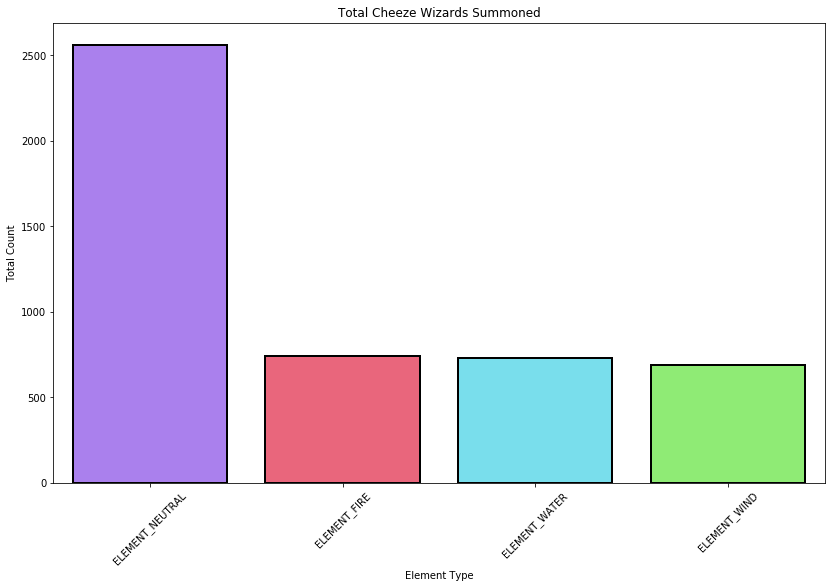

In [13]:
g = sns.countplot(
    x='element',
    data=df, 
    palette=wizard_colors,         
    linewidth=2,
    edgecolor=(0, 0, 0),
)

g.set_xticklabels(wizard_elements.values(), rotation=45)
g.set_title('Total Cheeze Wizards Summoned')
g.set_xlabel('Element Type')
g.set_ylabel('Total Count')
plt.tight_layout()

In [14]:
bn_min = df['blockNumber'].min()
bn_max = df['blockNumber'].max()

In [15]:
df['cumcount'] = df.sort_values(by='blockNumber').groupby(by=['element']).cumcount() + 1

In [16]:
df.head()

,blockNumber,costWei,element,id,owner,power,tokenId,cumcount
0,7781256,70000,1,0x000eead03c871a38ada29d0c5e93b2616da659d1454f...,0x8e1788f0f367542cfe2b81c3b43bc761cd1cba77,70,2485,288
1,7792622,70000,1,0x0024f9444c65af8b9ebe3ed08f2a421eb04cd4628e69...,0x4a9e7db01e359a3ff888e623dc41b38590b49d7b,70,3735,760
2,7783575,399160,4,0x002502f0a00864843f60121ace31dd3c59e0c922e13b...,0x16fce6f6b5579469e48cb9633105f36a52a0f9a6,399,3012,429
3,7782446,333212,3,0x002b0a8dccd55bfb239d353209d8b175ea3aac0b0bea...,0xfbdbcf1ebe27245e3488541f19cac902e53239a4,333,2811,394
4,7804891,70000,1,0x003fc311f62d3db875b467222cad13b75e49b7206bbe...,0x24cb9a6fb711911c53afa4d89c2fe8fbda034c41,70,4381,1171


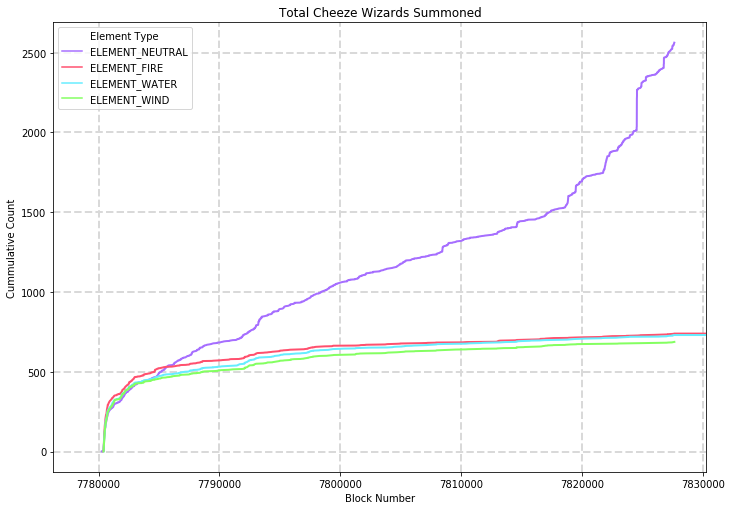

In [17]:
g = sns.lineplot(
    x="blockNumber", 
    y="cumcount",
    hue="element", 
    ci=None,
    estimator=None,
    palette=wizard_colors,         
    data=df,
    linewidth=2,
);

g.grid(True, lw = 2, ls = '--', c = '.85')

g.set_title('Total Cheeze Wizards Summoned')
g.set_xlim([bn_min - 4000, 7830273])
g.set_xlabel('Block Number')
g.set_ylabel('Cummulative Count')

legend = g.axes.legend()
legend.texts[0].set_text("Element Type")

for k, v in wizard_elements.items():
    legend.texts[k].set_text(v)